In [14]:
### merge adcp files from mule for 2024-1041. There are nc data on mule that cannot be open. 
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import cftime

In [15]:
### (1) plot 2024 SD-1041 streaks
### merge data from 
year = '2024'
platf_num = '1045'
path = '/Volumes/disk3/projects/sdig-external/sdig/saildrone/noaa_hurricane_2024/adcp/'+platf_num+'/'
### 
filenames_all = np.sort( os.listdir(path) )
print('Number of Files in for this directory on Mule:',len(filenames_all))
# pathout = os.getcwd()+'/fig_merge_raw_adcp/'
# if os.path.isdir(pathout):
#     pass
# else:
#     os.mkdir(pathout)
### retain the filenames wanted only
filenames = np.array([])
for file in filenames_all:
    if ('saildrone' in file) & ('.nc' in file):
        filenames = np.append(filenames, file)
print('Files have "saildrone" & ".nc" in the sub-directory on Mule:',len(filenames))
print(filenames)
### the list of variables I do not want for now
vars_no = ['trajectory','nav_start_time','nav_end_time','nav_start_latitude','nav_end_latitude',\
           'nav_start_longitude','nav_end_longitude','beam'] ### beam is added for 2024
### the list of variables that do not have time dimension (depth only)
vars_nostack = ['cell_depth']

Number of Files in for this directory on Mule: 16
Files have "saildrone" & ".nc" in the sub-directory on Mule: 16
['saildrone-gen_6-noaa_hurricane_2024-sd1045-20240910T000000-20240910T235959-5_minutes-v1.1726014650231.nc'
 'saildrone-gen_6-noaa_hurricane_2024-sd1045-20240911T000000-20240911T235959-5_minutes-v1.1726101031132.nc'
 'saildrone-gen_6-noaa_hurricane_2024-sd1045-20240912T000000-20240912T235959-5_minutes-v1.1726187430734.nc'
 'saildrone-gen_6-noaa_hurricane_2024-sd1045-20240913T000000-20240913T235959-5_minutes-v1.1726273821305.nc'
 'saildrone-gen_6-noaa_hurricane_2024-sd1045-20240914T000000-20240914T235959-5_minutes-v1.1726360273382.nc'
 'saildrone-gen_6-noaa_hurricane_2024-sd1045-20240915T000000-20240915T235959-5_minutes-v1.1726446626349.nc'
 'saildrone-gen_6-noaa_hurricane_2024-sd1045-20240916T000000-20240916T235959-5_minutes-v1.1726533021390.nc'
 'saildrone-gen_6-noaa_hurricane_2024-sd1045-20240918T000000-20240918T235959-5_minutes-v1.1726705827288.nc'
 'saildrone-gen_6-noaa

In [16]:
### try open the nc files and see how many can be opened
numOK = 0
numBAD = 0
filenames_canopen = []
for f in range( len(filenames) ):
    try: # block raising an exception
        ds = nc.Dataset(path+'/'+filenames[f])
        test = ds.variables['cell_depth'][:]
        ds.close()
        numOK = numOK + 1
        filenames_canopen.append(filenames[f])
        # print('Done',filenames[f])
    except: # doing nothing on exception
        numBAD = numBAD + 1
        # print('cannot open file:',filenames[f])
        pass
print(numOK,'can be open.')
print(numBAD,'cannot be open.')

10 can be open.
6 cannot be open.


In [17]:
### create a dictionary
vars_dic = {}
vars_dic_attr = {}
attr = ['long_name','units']
ds = nc.Dataset(path+'/'+filenames_canopen[0])
# print(ds)
nz = len( ds.variables['cell_depth'][:] )
varnms = list( ds.variables.keys() )
### add empty items to the dictionary 
for i in range( len(varnms) ):
    vkey = varnms[i]
    if vkey not in vars_no:
        item = ds.variables[vkey][:]
        vars_dic[vkey] = np.empty( item.shape )
        ### record attributes
        for a in range( len(attr) ):
            # ds.variables[vkey].units
            str_eval = "ds.variables['" + vkey + "']." + attr[a]
            vars_dic_attr[vkey+'-'+attr[a]] = eval(str_eval)
        # print(vkey, item.shape, vars_dic[vkey].shape)
print(len(varnms),'variables in nc file &', len(vars_dic),'variables are selected to append')
### go through each (mostly daily) nc file & append the selected variables 
for f in range( len(filenames_canopen) ):
    try: # block raising an exception
        ds = nc.Dataset(path+'/'+filenames_canopen[f])
        for i in range( len(varnms) ):
            vkey = varnms[i]
            if (vkey not in vars_no) & (vkey not in vars_nostack):
                # print(vkey)
                vkey = varnms[i]
                item_old = vars_dic[vkey]
                item_app = np.squeeze( ds.variables[vkey][:] ) # add np.squeeze for 2021
                ### append in time dimension only
                if f == 0:
                    vars_dic[vkey] = item_app
                else:
                    vars_dic[vkey] = np.concatenate( (item_old, item_app),axis=0 )
                if (f == 0):# | (f == len(filenames)-1):
                    vars_dic[vars_nostack[0]] = ds.variables[vars_nostack[0]][:]
                    # print(ds.variables[vkey]._FillValue)
                    # print(vkey,item_old.shape, item_app.shape, vars_dic[vkey].shape)
        ds.close()
        print('Done',filenames_canopen[f])
    except: # doing nothing on exception
        pass
    # cur_spd = np.sqrt( np.square(u)+np.square(v) )*100  # cm/s
print(vars_dic['time'].shape)

34 variables in nc file & 26 variables are selected to append
Done saildrone-gen_6-noaa_hurricane_2024-sd1045-20240910T000000-20240910T235959-5_minutes-v1.1726014650231.nc
Done saildrone-gen_6-noaa_hurricane_2024-sd1045-20240914T000000-20240914T235959-5_minutes-v1.1726360273382.nc
Done saildrone-gen_6-noaa_hurricane_2024-sd1045-20240915T000000-20240915T235959-5_minutes-v1.1726446626349.nc
Done saildrone-gen_6-noaa_hurricane_2024-sd1045-20240916T000000-20240916T235959-5_minutes-v1.1726533021390.nc
Done saildrone-gen_6-noaa_hurricane_2024-sd1045-20240918T000000-20240918T235959-5_minutes-v1.1726705827288.nc
Done saildrone-gen_6-noaa_hurricane_2024-sd1045-20240919T000000-20240919T235959-5_minutes-v1.1726792260265.nc
Done saildrone-gen_6-noaa_hurricane_2024-sd1045-20240925T000000-20240925T235959-5_minutes-v1.1727310627144.nc
Done saildrone-gen_6-noaa_hurricane_2024-sd1045-20240926T000000-20240926T235959-5_minutes-v1.1727397014438.nc
Done saildrone-gen_6-noaa_hurricane_2024-sd1045-20240927T0

(700,) (700,)
is time_out monotonic? --> True
(700,) (700,)
<class 'tuple'> 2 [21870000. 21870300. 21870600. 21870900. 21871200. 21871500. 21871800.
 21872100. 21872400. 21872700. 21873000. 21873300. 21942600. 21943200.
 21943800. 21944400. 21945000. 22208400. 22209000. 22209600. 22210200.
 22210800. 22211400. 22212000. 22212600. 22213200. 22213800. 22214400.
 22215000. 22215600. 22216200. 22216800. 22217400. 22218000. 22218600.
 22219200. 22219800. 22220400. 22221000. 22221600. 22222200. 22222800.
 22223400. 22224000. 22224600. 22225200. 22225800. 22226400. 22227000.
 22227600. 22228200. 22228800. 22229400. 22230000. 22230600. 22231200.
 22231800. 22232400. 22233000. 22233600. 22234200. 22234800. 22235400.
 22236000. 22236600. 22237200. 22237800. 22238400. 22239000. 22239600.
 22240200. 22240800. 22241400. 22242000. 22242600. 22243200. 22243800.
 22244400. 22245000. 22245600. 22246200. 22246800. 22247400. 22248000.
 22248600. 22249200. 22249800. 22250400. 22251000. 22251600. 22252200.

<Figure size 432x288 with 0 Axes>

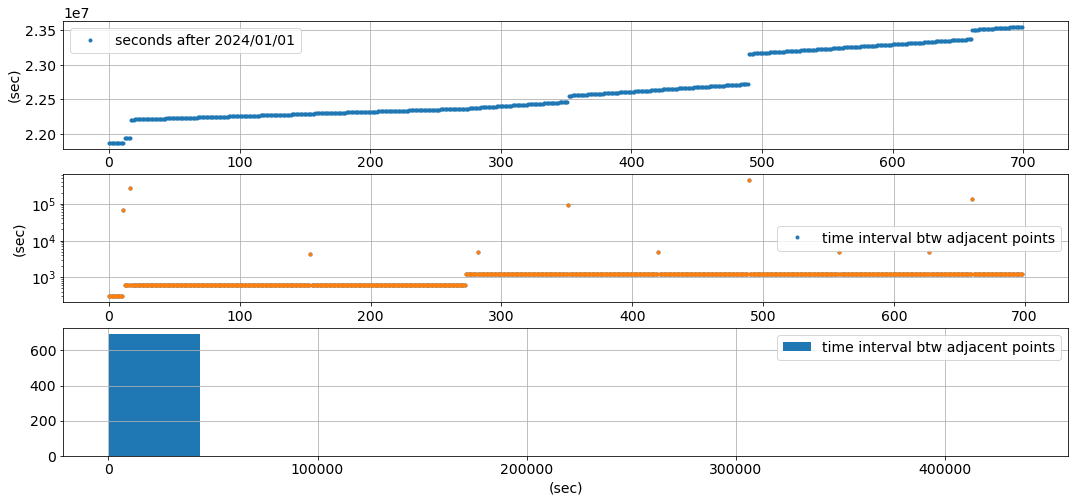

In [18]:
### compute the time as seconds since year-01-01
dtime = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds= vars_dic['time'][i]) for i in range(len(vars_dic['time']))])
time_out = np.array([(dtime[i]-datetime.datetime(int(year),1,1)).total_seconds() for i in range(len(dtime))])
print(dtime.shape, time_out.shape)
### check if time is monotonic and unique
def isMonotonic(A):
    return (all(A[i] <= A[i + 1] for i in range(len(A) - 1)) or
            all(A[i] >= A[i + 1] for i in range(len(A) - 1)))
print('is time_out monotonic? -->', isMonotonic(time_out))

nrow = 3
plt.clf()
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrow,1, figsize=(18, 8))
plt.subplot(nrow,1,1)
plt.plot(time_out,'.',label='seconds after '+year+'/01/01')
plt.ylabel('(sec)'); plt.legend()
plt.subplot(nrow,1,2)
plt.semilogy(np.diff(np.sort(time_out)),'.',label='time interval btw adjacent points')
plt.semilogy(np.diff(time_out),'.')
plt.ylabel('(sec)'); plt.legend()
plt.subplot(nrow,1,3)
plt.hist(np.diff(np.sort(time_out)),label='time interval btw adjacent points')
plt.xlabel('(sec)'); plt.legend()
### figure settings
for i in range( nrow ):
    plt.subplot(nrow,1,i+1)
    plt.grid()
print(np.unique(time_out).shape, time_out.shape)
test = np.unique(time_out, return_index=False, return_inverse=False, return_counts=True)
print(type(test), len(test), test[0])

dict_keys(['time', 'latitude', 'longitude', 'cell_depth', 'roll', 'pitch', 'heading', 'vel_east', 'vel_north', 'vel_up', 'error_vel', 'echo_intensity', 'correlation', 'vehicle_vel_north', 'vehicle_vel_east', 'vehicle_vel_up', 'bt_range', 'bt_cor', 'bt_vel_east', 'bt_vel_north', 'bt_vel_up', 'bt_amp', 'bt_percent_good', 'percent_good_4_beam', 'percent_good_3_beam', 'percent_good'])
time (700,)
latitude (700,)
longitude (700,)
roll (700,)
pitch (700,)
heading (700,)
vel_east (700, 50)
vel_north (700, 50)
vel_up (700, 50)
error_vel (700, 50)
echo_intensity (700, 4, 50)
correlation (700, 4, 50)
vehicle_vel_north (700,)
vehicle_vel_east (700,)
vehicle_vel_up (700,)
bt_range (700, 4)
bt_cor (700, 4)
bt_vel_east (700,)
bt_vel_north (700,)
bt_vel_up (700,)
bt_amp (700, 4)
bt_percent_good (700, 4)
percent_good_4_beam (700, 50)
percent_good_3_beam (700, 50)
percent_good (700, 50)


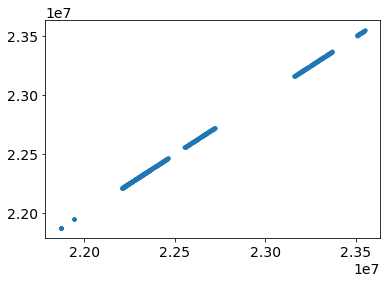

In [19]:
### sort data so that the time is monotonically increasing --> then find unique time
it_sort = np.argsort(time_out)
time_sort = time_out[it_sort]
time_uniq, it_uniq = np.unique(time_sort, return_index=True)
plt.plot(time_uniq, time_sort[it_uniq],'.')

vkey_all = vars_dic.keys()
print(vkey_all)
for vkey in vkey_all:
    if vkey != 'cell_depth':
        if np.ndim(vars_dic[vkey]) == 1:
            data = vars_dic[vkey][it_sort]
            data_uniq = data[it_uniq]            
        elif np.ndim(vars_dic[vkey]) == 2:
            data = vars_dic[vkey][it_sort,:]
            data_uniq = data[it_uniq,:]
        elif np.ndim(vars_dic[vkey]) == 3:
            data = vars_dic[vkey][it_sort,:,:]
            data_uniq = data[it_uniq,:,:]
        ## replace
        vars_dic[vkey] = data_uniq
        print(vkey,vars_dic[vkey].shape)

In [23]:
print(np.diff(time_uniq[0:5]))

[300. 300. 300. 300.]


In [24]:
### write merged adcp data to netcdf file: https://unidata.github.io/python-training/workshop/Bonus/netcdf-writing/
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
ncfname_out = 'adcp-5min-merge-'+year+'-SD'+platf_num+'.nc'
# if os.path.exists( ncfname_out ):
#     os.remove('adcp-5min-merge-'+year+'-SD'+platf_num+'.nc')
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
depth_dim = ncfile.createDimension('depth', len(vars_dic['cell_depth'])) # depth axis
time_dim = ncfile.createDimension('time', len(time_uniq)) # unlimited axis (can be appended to).
beam_dim = ncfile.createDimension('beam', 4)
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='Merged files for '+year+' SD-'+platf_num
print(ncfile.title)
ncfile.subtitle="Only selected variables for adcp measurements are here. Temporal resolution is ~5-minute."
print(ncfile.subtitle)
print(ncfile)
### move the writing data to new variables
depth_out = vars_dic['cell_depth']

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('depth', <class 'netCDF4._netCDF4.Dimension'>: name = 'depth', size = 50)
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 700)
('beam', <class 'netCDF4._netCDF4.Dimension'>: name = 'beam', size = 4)
Merged files for 2024 SD-1045
Only selected variables for adcp measurements are here. Temporal resolution is ~5-minute.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2024 SD-1045
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~5-minute.
    dimensions(sizes): depth(50), time(700), beam(4)
    variables(dimensions): 
    groups: 


In [25]:
### Creating variables
depth = ncfile.createVariable('depth', np.float64, ('depth',))
depth.units = 'meter'
depth.long_name = 'depth'
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
### 1D variables
vars_names = ['longitude','latitude','pitch','roll','heading','vehicle_vel_east','vehicle_vel_north','vehicle_vel_up','bt_vel_east','bt_vel_north','bt_vel_up',\
           'vel_east','vel_north','vel_up','error_vel','percent_good_4_beam','percent_good_3_beam','percent_good',\
            'bt_range','bt_cor','bt_amp','bt_percent_good',\
                'echo_intensity','correlation']
### 1: (time,) 2: (time, cell_depth) 3: (time, beam) 4: (time, beam, cell_depth)
dim_cat = [1,1,1,1,1,1,1,1,1,1,1,\
      2,2,2,2,2,2,2,\
        3,3,3,3,\
            4,4]
for i in range( len(vars_names) ):
    ### create variables with respective dimensions categorized by dim_cat
    if dim_cat[i] == 1:
        str_exec = vars_names[i] + "= ncfile.createVariable('" + vars_names[i] + "', np.float64, ('" + 'time' + "',))"
        exec(str_exec)
        print(i,str_exec)
    elif dim_cat[i] == 2:
        str_exec = vars_names[i] + "= ncfile.createVariable('" + vars_names[i] + "', np.float64, ('" + 'time' + "','"+ 'depth' +"'))"
        exec(str_exec)
        print(i,str_exec)
    elif dim_cat[i] == 3:
        str_exec = vars_names[i] + "= ncfile.createVariable('" + vars_names[i] + "', np.float64, ('" + 'time' + "','"+ 'beam' +"'))"
        exec(str_exec)
        print(i,str_exec)
    else: 
        str_exec = vars_names[i] + "= ncfile.createVariable('" + vars_names[i] + \
            "', np.float64, ('" + 'time' + "','"+ 'beam' + "','" + 'depth' +"'))"
        exec(str_exec)
        print(i,str_exec)
     # ### add attributes
    for a in range( len(attr) ):
        str_exec = vars_names[i] + "."+ attr[a] + " = '"+ vars_dic_attr[vars_names[i]+'-'+attr[a]] + "'"
        print(str_exec)
        exec(str_exec)

0 longitude= ncfile.createVariable('longitude', np.float64, ('time',))
longitude.long_name = 'Longitude'
longitude.units = 'degrees_east'
1 latitude= ncfile.createVariable('latitude', np.float64, ('time',))
latitude.long_name = 'Latitude'
latitude.units = 'degrees_north'
2 pitch= ncfile.createVariable('pitch', np.float64, ('time',))
pitch.long_name = 'platform pitch angle'
pitch.units = 'Degree'
3 roll= ncfile.createVariable('roll', np.float64, ('time',))
roll.long_name = 'platform roll angle'
roll.units = 'Degree'
4 heading= ncfile.createVariable('heading', np.float64, ('time',))
heading.long_name = 'Vehicle heading'
heading.units = 'Degree'
5 vehicle_vel_east= ncfile.createVariable('vehicle_vel_east', np.float64, ('time',))
vehicle_vel_east.long_name = 'Vehicle velocity eastward'
vehicle_vel_east.units = '(mm)s-1'
6 vehicle_vel_north= ncfile.createVariable('vehicle_vel_north', np.float64, ('time',))
vehicle_vel_north.long_name = 'Vehicle velocity northward'
vehicle_vel_north.units = 

In [26]:
### writing data
# Note: the ":" is necessary in these "write" statements
depth[:] = depth_out
time[:] = time_uniq
for i in range( len(vars_names) ):
    if dim_cat[i] == 1:
        str_exec = vars_names[i] + "[:]= vars_dic['" + vars_names[i] + "']"
    elif (dim_cat[i] == 2 ) | (dim_cat[i] == 3):
        str_exec = vars_names[i] + "[:,:]= vars_dic['" + vars_names[i] + "']"
    else:
        str_exec = vars_names[i] + "[:,:,:]= vars_dic['" + vars_names[i] + "']"
    exec(str_exec)    
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for 2024 SD-1045
    subtitle: Only selected variables for adcp measurements are here. Temporal resolution is ~5-minute.
    dimensions(sizes): depth(50), time(700), beam(4)
    variables(dimensions): float64 depth(depth), float64 time(time), float64 longitude(time), float64 latitude(time), float64 pitch(time), float64 roll(time), float64 heading(time), float64 vehicle_vel_east(time), float64 vehicle_vel_north(time), float64 vehicle_vel_up(time), float64 bt_vel_east(time), float64 bt_vel_north(time), float64 bt_vel_up(time), float64 vel_east(time, depth), float64 vel_north(time, depth), float64 vel_up(time, depth), float64 error_vel(time, depth), float64 percent_good_4_beam(time, depth), float64 percent_good_3_beam(time, depth), float64 percent_good(time, depth), float64 bt_range(time, beam), float64 bt_cor(time, beam), float64 bt_amp(time, beam), float64 bt_percent_goo

min time difference= 300.0 sec
1st & last time in file: 09/10 03:00Z 09/29 13:40Z
10 time gaps that are > 30 min
The corresponding time gaps (in mins) [1155. 4390.   70.   80. 1520.   80. 7280.   80.   80. 2240.]
09/10 03:55Z - 09/10 23:10Z
09/10 23:50Z - 09/14 01:00Z
09/14 23:50Z - 09/15 01:00Z
09/15 23:40Z - 09/16 01:00Z
09/16 23:40Z - 09/18 01:00Z
09/18 23:40Z - 09/19 01:00Z
09/19 23:40Z - 09/25 01:00Z
09/25 23:40Z - 09/26 01:00Z
09/26 23:40Z - 09/27 01:00Z
09/27 11:40Z - 09/29 01:00Z


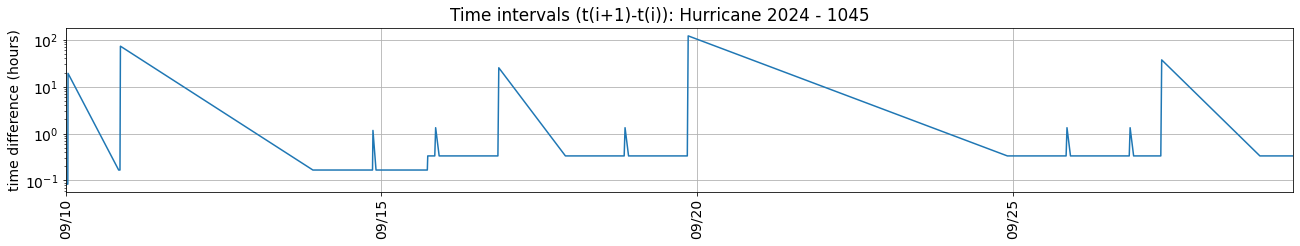

In [27]:
### plot time intervals (time(i+1)-time(i)) and print time gaps
fig, axes = plt.subplots(1)
fig.set_size_inches(22,3)
test = vars_dic['time']
dtime = np.array([datetime.datetime(1970,1,1)+datetime.timedelta(seconds= vars_dic['time'][i]) for i in range(len(vars_dic['time']))])
dtest = np.array([(test[i+1]-test[i])/3600 for i in range( len(test)-1 )]) # 
plt.semilogy(dtime[:-1],dtest)
ddays = (np.max(dtime)-np.min(dtime)).days
xticks = [np.min(dtime)+datetime.timedelta(days=5*i) for i in range(ddays)]
xtickslabel = [xticks[i].strftime('%m/%d') for i in range(ddays)]
plt.xticks(xticks)
plt.gca().set_xticklabels(xtickslabel, rotation=90)
plt.ylabel('time difference (hours)')
plt.xlim([dtime[0],dtime[-1]])
plt.grid()
print('min time difference=',np.min(dtest)*3600,'sec')
print('1st & last time in file:',dtime[0].strftime('%m/%d %H:%MZ'),dtime[-1].strftime('%m/%d %H:%MZ'))
### find data gaps
d5min = (datetime.datetime(int(year),1,1,0,5,0)-datetime.datetime(int(year),1,1)).total_seconds()/3600
d10min = (datetime.datetime(int(year),1,1,0,10,0)-datetime.datetime(int(year),1,1)).total_seconds()/3600
d30min = (datetime.datetime(int(year),1,1,0,30,0)-datetime.datetime(int(year),1,1)).total_seconds()/3600
d60min = (datetime.datetime(int(year),1,1,1,0,0)-datetime.datetime(int(year),1,1)).total_seconds()/3600
# i_tgap = np.where( dtest > d30min )[0]
i_tgap = np.where( dtest > d30min )[0]
print(len(i_tgap),'time gaps that are > 30 min')
print('The corresponding time gaps (in mins)',dtest[i_tgap]*60)
for i in range( len(i_tgap) ):
    print(dtime[i_tgap[i]].strftime('%m/%d %H:%MZ'),'-',dtime[i_tgap[i]+1].strftime('%m/%d %H:%MZ'))

plt.suptitle('Time intervals (t(i+1)-t(i)): Hurricane '+year+' - '+platf_num)
### save figure
fig.savefig('time_intervals_'+year+'-'+platf_num+'-adcp.png', dpi=300,bbox_inches='tight')